In [7]:
import numpy as np
from numpy import random
import random
import matplotlib.pyplot as plt
from scipy.signal import cwt,ricker
from scipy import stats
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.preprocessing import MinMaxScaler

import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"   
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.optimizers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.layers import Flatten,concatenate,Layer,Dense,LSTM,Activation,MaxPooling2D,Dropout,Conv2D,BatchNormalization,Reshape,UpSampling2D,ZeroPadding2D
import nibabel as nib
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import tensorflow_io as tfio
import radiomics
from radiomics import featureextractor,firstorder
import SimpleITK as sitk


In [8]:
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
CUDA_VISIBLE_DEVICES=0

In [9]:
tf.test.is_built_with_cuda()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4122194470782375995
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 32493010944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6420861324911211377
physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:16:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


2022-07-12 02:28:40.844789: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:16:00.0, compute capability: 7.0


In [5]:
#data https://wiki.cancerimagingarchive.net/display/Public/Lung+CT+Segmentation+Challenge+2017

2022-07-12 02:24:28.021356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:16:00.0, compute capability: 7.0
2022-07-12 02:24:28.593711: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2022-07-12 02:24:28.594151: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA


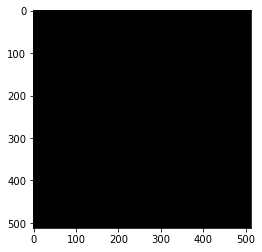

In [6]:
mk = tf.io.read_file('./out.dcm' )
mkf = tfio.image.decode_dicom_image(mk, color_dim=True,scale='auto',on_error='lossy', dtype=tf.uint8)[0]
plt.imshow(np.squeeze(mkf.numpy()), cmap='gray')

In [18]:
mask = np.ones((512,512,512))
print(mask.shape)

(512, 512, 512)


In [19]:
castFilter = sitk.CastImageFilter()
castFilter.SetOutputPixelType(sitk.sitkUInt16)

# Convert floating type image (imgSmooth) to int type (imgFiltered)
imgFiltered = castFilter.Execute(mask_file)

In [3]:
# function return a mean feature of a single image
def GetMean(data):

    return np.mean(data.reshape(len(data[0])*len(data)))

def GetStd(data):

    return np.std(data.reshape(len(data[0])*len(data)))

def GetSkew(data):
    return stats.skew(data.reshape(len(data[0])*len(data)))

def GetKurtosis(data):
    return stats.kurtosis(data.reshape(len(data[0])*len(data)))


    
# ddd = np.array([[[1],[2],[3]],[[3],[2],[1]],[[2],[2],[2]]])
# ddd.shape
# print(GetMean(ddd))

In [ ]:


# load data files
def Load_data_dicts(foldernames):
    result = []
    for i in foldernames:
        files  = tf.io.gfile.listdir('./Lung_Train/' + i)
        for j in files:
            result.append(tf.io.read_file('./Lung_Train/'+ i +'/' + j ))
    return result

image_bytes = Load_data_dicts(['d1','d2', 'd3', 'd4','d5','d6','d7','d8','d9','d10','d11','d12',
                              'd2_1','d2_2', 'd2_3', 'd2_4','d2_5','d2_6','d2_7','d2_8','d2_9','d2_10','d2_11','d2_12'
                              ,'d3_1','d3_2', 'd3_3', 'd3_4','d3_5','d3_6','d3_7','d3_8'
                              ,'d3_9','d3_10','d3_11','d3_12'
                              ])


# print(np.array(image_bytes).shape)
# # files = tf.io.gfile.listdir('./Lung_Train/d1')
# # files2 = tf.io.gfile.listdir('./Lung_Train/d2')
filestest = Load_data_dicts(['t1','t3',"t2","t4"])

2022-07-11 01:20:44.880457: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-11 01:20:44.880556: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: csn-033
2022-07-11 01:20:44.880587: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: csn-033
2022-07-11 01:20:44.880716: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.82.1
2022-07-11 01:20:44.880768: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.82.1
2022-07-11 01:20:44.880780: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.82.1


In [6]:
# load the image data 
# image_bytes=[]
# image_bytestest = []
# for i in files:
#     image_bytes.append(tf.io.read_file('./Lung_Train/d1/'+ i))
# for i in files2:
#     image_bytes.append(tf.io.read_file('./Lung_Train/d2/'+ i))
    
    
    
# for i in filestest:
#     image_bytestest.append(tf.io.read_file('./Lung_Train/t1/'+ i))

In [7]:
#i = tf.io.gfile.GFile('./Lung_Train/d1/1-001.dcm').read(-1)


In [8]:
#scale it to unit8
images = []
imagestest = []
for i in image_bytes:
    image = tfio.image.decode_dicom_image(i, color_dim=True,scale='auto',on_error='lossy', dtype=tf.uint8)[0]
    images.append(image)
    
for i in filestest:
    imagetest = tfio.image.decode_dicom_image(i, color_dim=True,scale='auto',on_error='lossy', dtype=tf.uint8)[0]
    imagestest.append(imagetest)

2022-07-09 22:23:40.335880: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2022-07-09 22:23:40.336975: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


In [9]:
images = np.array(images)
imagestest = np.array(imagestest)
#imagestest = np.array(imagesval)
images.shape
#imagestest.shape

(5819, 512, 512, 1)

In [18]:
# output_mean image data
output_mean_image = []
output_mean_imagetest = []

output_std_image = []
output_std_imagetest  = []

for i in images:
    output_mean_image.append(GetMean(i))
    output_std_image.append(GetStd(i))
    
for i in imagestest:
    output_mean_imagetest.append(GetMean(i))
    output_std_imagetest.append(GetStd(i))
    
output_mean_image= np.array(output_mean_image)
output_std_image= np.array(output_std_image)

output_mean_imagetest= np.array(output_mean_imagetest)
output_std_imagetest= np.array(output_std_imagetest)
# output_mean_imagetest.shape

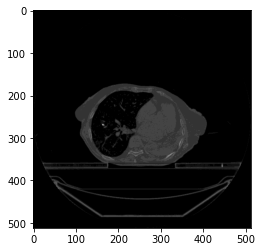

In [19]:
plt.imshow(np.squeeze(image.numpy()), cmap='gray')

# After Loading, train to get the mean FIN

In [17]:
input_layer = keras.Input(shape=(512,512,1))
x = Flatten()(input_layer)
mean_1 = Dense(128, activation='relu')(x)
mean_2 = Dense(128, activation='relu')(mean_1)
mean_3 = Dense(128, activation='relu')(mean_2)
mean_4 = Dense(128, activation='relu')(mean_3)
mean_5 = Dense(128, activation='relu')(mean_4)
mean_out = Dense(1, activation = 'linear', name = 'mean')(mean_5)

meanModel = keras.Model(input_layer, mean_out, name= "mean")

In [29]:
meanModel.compile(optimizer=tf.keras.optimizers.Adam(
   learning_rate= 0.0000001
), loss="mean_squared_error")
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)

In [36]:
# meanModel.fit(images, output_mean_image, 
#              # validation_data=(imagesval,output_mean_imageval), 
#               epochs=1000, batch_size=64,
#              #callbacks=[es],
#                 shuffle=True)


18/18 [==============================] - 0s 12ms/step


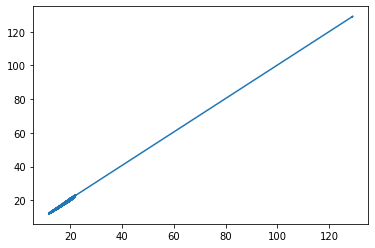

In [33]:
#plt.plot(range(50),output_mean_imagetest[:50] ,range(50),meanModel.predict(imagestest)[:50] )

plt.plot(output_mean_imagetest ,meanModel.predict(imagestest) )
#meanModel.predict(imagestest).shape
#output_mean_imagetest.shape

In [197]:
#extractor = featureextractor.RadiomicsFeatureExtractor()
#extractor.execute('./Lung_Train/1-001.dcm','./Lung_Train/1-001.dcm')

In [37]:
#meanModel.save(("./radiomics_mean_512.h5"))

In [30]:
# evaluate the mean Model
#meanModel = load_model("./radiomics_mean_512.h5")
meanModel.evaluate(imagestest, output_mean_imagetest)

18/18 [==============================] - 0s 12ms/step - loss: 0.1568


0.1567588895559311

In [ ]:
# we can see from the test set the model predict pretty good feature value

In [75]:
input_layer = keras.Input(shape=(512,512,1))
x = Flatten()(input_layer)
std_1 = Dense(128, activation='relu')(x)
std_2 = Dense(256, activation='relu')(std_1)
std_3 = Dense(256, activation='relu')(std_2)
std_4 = Dense(256, activation='relu')(std_3)
std_5 = Dense(256, activation='relu')(std_4)
std_6 = Dense(128, activation='relu')(std_5)
std_7 = Dense(64, activation='relu')(std_6)

std_out = Dense(1, activation = 'linear', name = 'std')(std_7)

stdModel = keras.Model(input_layer, std_out, name= "std")

In [43]:

#stdModel = load_model("./radiomics_std13_512.h5")

stdModel.compile(optimizer=tf.keras.optimizers.Adam(
  learning_rate= 0.0000001
), loss="mean_squared_error")

In [48]:


# stdModel.fit(images, output_std_image, 
#              # validation_data=(imagesval,output_mean_imageval), 
#               epochs=100, batch_size=32,
#              #callbacks=[es],
#                 shuffle=True
#             )

In [49]:
stdModel.save(("./radiomics_std13_512.h5"))

18/18 [==============================] - 0s 10ms/step


0.07194969803094864

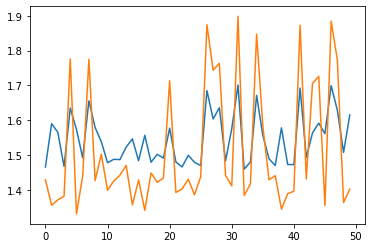

In [46]:
plt.plot(range(50),output_std_imagetest[0:50] ,range(50),stdModel.predict(imagestest)[0:50] )

#plt.plot(output_std_imagetest ,stdModel.predict(imagestest) )
stdModel.evaluate(imagestest, output_std_imagetest, verbose=0)


In [10]:
# output skew and kurtsis image data
output_skew_image = []
output_kur_image = []

output_skew_imagetest = []
output_kur_imagetest  = []

for i in images:
    output_skew_image.append(GetSkew(i))
    output_kur_image.append(GetKurtosis(i))
    
for i in imagestest:
    output_skew_imagetest.append(GetSkew(i))
    output_kur_imagetest.append(GetKurtosis(i))
    
output_skew_image= np.array(output_skew_image)
output_kur_image= np.array(output_kur_image)

output_skew_imagetest= np.array(output_skew_imagetest)
output_kur_imagetest= np.array(output_kur_imagetest)

In [128]:
input_layer = keras.Input(shape=(512,512,1))
x = Flatten()(input_layer)
skew1 = Dense(128, activation='relu')(x)
skew2 = Dense(128, activation='relu')(skew1)
firstout = Dense(1, activation = 'linear', name = 'mean')(skew2)

dskew_1 = Dense(128, activation='relu')(x)
dskew_2 = Dense(128, activation='relu')(dskew_1)
dskew_3 = Dense(128, activation='relu')(dskew_2)

secondout = Dense(1, activation = 'linear', name = 'std')(dskew_3)


n_d = concatenate([firstout,secondout])

nd1 = Dense(128, activation='relu')(n_d)
nd2 = Dense(256, activation='relu')(nd1)
nd3 = Dense(256, activation='relu')(nd2)
nd4 = Dense(256, activation='relu')(nd3)
nd5 = Dense(256, activation='relu')(nd4)



skew_out = Dense(1, activation = 'linear', name= 'skewness')(nd5)

skewModel = keras.Model(input_layer, skew_out, name= "skewness")

In [155]:

skewModel.compile(optimizer=tf.keras.optimizers.Adam(
 learning_rate= 0.0000000001
), loss="mean_squared_error")



In [156]:
skewModel.fit(images, output_skew_image, 
             # validation_data=(imagesval,output_mean_imageval), 
              epochs=5, batch_size=32,
             #callbacks=[es],
                shuffle=True)

Epoch 1/5
182/182 [==============================] - 10s 49ms/step - loss: 0.6594
Epoch 2/5
182/182 [==============================] - 9s 51ms/step - loss: 0.6578
Epoch 3/5
182/182 [==============================] - 10s 54ms/step - loss: 0.6562
Epoch 4/5
182/182 [==============================] - 9s 51ms/step - loss: 0.6546
Epoch 5/5
182/182 [==============================] - 9s 50ms/step - loss: 0.6530


18/18 [==============================] - 0s 16ms/step


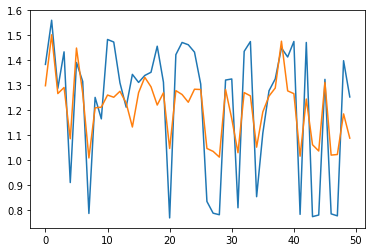

In [157]:
plt.plot(range(50),output_skew_imagetest[0:50] ,range(50),skewModel.predict(imagestest)[0:50] )

In [158]:
skewModel.save("./radiomics_skew3_512.h5")

In [11]:
input_layer = keras.Input(shape=(512,512,1))
i = Flatten()(input_layer)
i = BatchNormalization(axis=1)(i)
x = Dense(64, activation='relu')(i)
x1 = Dense(64, activation='relu')(x)
firstout = Dense(1, activation = 'linear', name = 'mean')(x1)

z = Dense(64, activation='relu')(i)
z = Dense(64, activation='relu')(z)
z1 = Dense(64, activation='relu')(z)

secondout = Dense(1, activation = 'linear', name = 'std')(z1)


n_d = concatenate([firstout,secondout])

nd1 = Dense(64, activation='relu')(n_d)
nd2 = Dense(128, activation='relu')(nd1)
nd3 = Dense(256, activation='relu')(nd2)
nd4 = Dense(256, activation='relu')(nd3)
nd5 = Dense(128, activation='relu')(nd4)
nd6 = Dense(64, activation='relu')(nd5)


kur_out = Dense(1, activation = 'linear', name= 'kur')(nd6)

kurModel = keras.Model(input_layer, kur_out, name= "kur")



In [103]:
kurModel.compile(optimizer=tf.keras.optimizers.Adam(
  learning_rate= 0.00000001
), loss="mse")



In [108]:
# kurModel.fit(images, output_kur_image, 
#              # validation_data=(imagesval,output_mean_imageval), 
#               epochs=500, batch_size=128,
#              #callbacks=[es],
#                 shuffle=True
#             )

18/18 [==============================] - 0s 12ms/step


2.0300159454345703

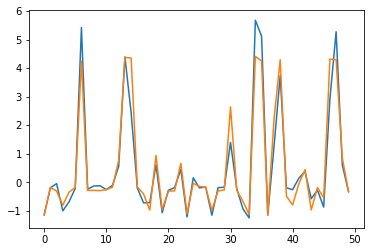

In [106]:
#kurModel = load_model("./radiomics_kur6_512.h5")

#plt.plot(range(50),output_kur_imagetest[:50] ,range(50),kurModel.predict(imagestest)[:50] )
plt.plot(range(50),output_kur_imagetest[150:200] ,range(50),kurModel.predict(imagestest)[150:200] )

#plt.plot(output_kur_imagetest ,kurModel.predict(imagestest))
kurModel.evaluate(imagestest, output_kur_imagetest, verbose=0)

In [107]:
kurModel.save("./radiomics_kur8_512.h5")